# COVID-19 Detection in Chest X-Ray Images
The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1) (https://data.mendeley.com/datasets/fvk7h5dg2p/1).

In [10]:
# Download and unzip
dataroot = "Capstone/dataroot/"
# !mkdir dataroot
# downloaded and unzipped manually because it was not working
# !wget -P dataroot https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
# !pip install -r requirements.txt
# !pip install scikit-image


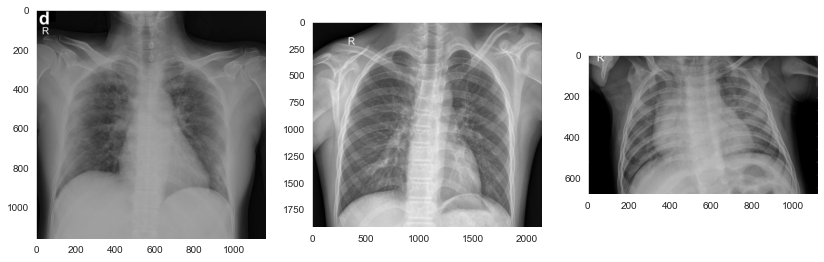

In [11]:
# Load and preview images
import matplotlib.pyplot as plt
# !pip install opencv-python
import cv2

img_covid     = cv2.imread(dataroot+'COVID-19 cases/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal_/IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person1650_virus_2854.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.grid(False)
plt.imshow(img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.grid(False)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.grid(False)
plt.imshow(img_pneumonia,cmap='gray')

# Data Preparation

In [12]:
# Confirming pixel values are 0-255 and not 1-256
maxima = []
for i in range(len(img_normal)):
    maxima.append(max(img_normal[i]))
print(max(maxima))

255


In [13]:
import numpy as np
import os
import skimage
import pandas as pd
image_df = pd.DataFrame()
lst_image_arrays = []
lst_image_class = []
folders = os.listdir(dataroot)
for folder in folders:
    subfolder = str(dataroot + folder)
    for jpeg in os.listdir(subfolder):
        # imports grayscale image
        image = cv2.imread(dataroot+folder+"/"+jpeg,0)
        # converts images to array of floats from 0 to 1
        image = np.array(image, dtype = np.float64)/255
        image = skimage.transform.resize(image, (256, 256, 1))
        flat_image = image.flatten()
        lst_image_arrays.append(flat_image)
        lst_image_class.append(str(folder))
image_df['Image Array'] = lst_image_arrays
image_df['Classification'] = lst_image_class


In [14]:
print(image_df.head())

                                         Image Array  Classification
0  [0.5188462849190497, 0.4861126092850482, 0.451...  COVID-19 cases
1  [0.20144823786957128, 0.2022097578947339, 0.19...  COVID-19 cases
2  [0.1683706570770056, 0.18296309272772182, 0.19...  COVID-19 cases
3  [0.04875122295393777, 0.04889640187995805, 0.0...  COVID-19 cases
4  [0.02622097550721793, 0.010478510439611413, 0....  COVID-19 cases


In [15]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
image_df['Classification'] = enc.fit_transform(image_df['Classification'])
print(image_df.head())

                                         Image Array  Classification
0  [0.5188462849190497, 0.4861126092850482, 0.451...               0
1  [0.20144823786957128, 0.2022097578947339, 0.19...               0
2  [0.1683706570770056, 0.18296309272772182, 0.19...               0
3  [0.04875122295393777, 0.04889640187995805, 0.0...               0
4  [0.02622097550721793, 0.010478510439611413, 0....               0


In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(image_df['Image Array']),image_df['Classification'],test_size=0.20,random_state=42)
print(x_train[1])

[0.55574445 0.55105613 0.54133295 ... 0.         0.         0.        ]


# Models from defaults
Scoring is balanced accuracy score due to imbalanced class sizes

In [31]:
# sklearn import statements (Note: PyCharm IDE has confusing import behavior so some import statements are repeated)
from sklearn.model_selection import GridSearchCV
from sklearn import svm, metrics
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

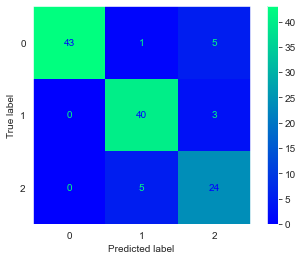

Confusion Matrix for Default LSVC
[[43  1  5]
 [ 0 40  3]
 [ 0  5 24]]
              precision    recall  f1-score   support

    COVID-19       1.00      0.88      0.93        49
      Normal       0.87      0.93      0.90        43
   Pneumonia       0.75      0.83      0.79        29

    accuracy                           0.88       121
   macro avg       0.87      0.88      0.87       121
weighted avg       0.89      0.88      0.89       121

Balanced accuracy score:
0.8784565951480833


In [41]:
# Default LinearSVC, random state set for repeatable results
def_lsvc_clf = svm.LinearSVC(random_state=42, tol=1e-2, max_iter=2000).fit(list(x_train), y_train)
y_pred_def_lsvc = def_lsvc_clf.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_def_lsvc)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_def_lsvc, cmap = 'winter')
plt.grid(False)
plt.show()
print('Confusion Matrix for Default LSVC')
print(cm)
print((metrics.classification_report(y_test, y_pred_def_lsvc, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print('Balanced accuracy score:')
print(metrics.balanced_accuracy_score(y_test, y_pred_def_lsvc))

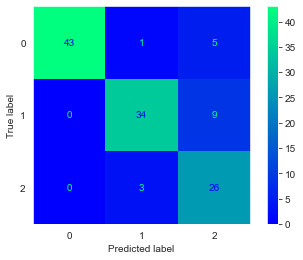

Confusion Matrix for Default SGDC
[[43  1  5]
 [ 0 34  9]
 [ 0  3 26]]
              precision    recall  f1-score   support

    COVID-19       1.00      0.88      0.93        49
      Normal       0.89      0.79      0.84        43
   Pneumonia       0.65      0.90      0.75        29

    accuracy                           0.85       121
   macro avg       0.85      0.85      0.84       121
weighted avg       0.88      0.85      0.86       121

Balanced accuracy score:
0.854933472988233


In [33]:
# Default SGDClassifier, random state set for repeatable results
def_sgd_clf = SGDClassifier(random_state=42).fit(list(x_train), y_train)
y_pred_def_sgd = def_sgd_clf.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_def_sgd)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_def_sgd, cmap = 'winter')
plt.grid(False)
plt.show()
print('Confusion Matrix for Default SGDC')
print(cm)
print((metrics.classification_report(y_test, y_pred_def_sgd, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print('Balanced accuracy score:')
print(metrics.balanced_accuracy_score(y_test, y_pred_def_sgd))

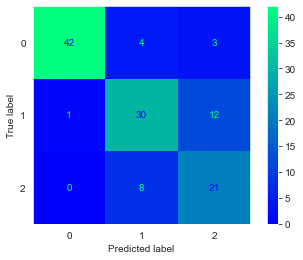

Confusion Matrix for Default KNNC
[[42  4  3]
 [ 1 30 12]
 [ 0  8 21]]
              precision    recall  f1-score   support

    COVID-19       0.98      0.86      0.91        49
      Normal       0.71      0.70      0.71        43
   Pneumonia       0.58      0.72      0.65        29

    accuracy                           0.77       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.79      0.77      0.78       121

Balanced accuracy score:
0.759651735593997


In [34]:
# Default KNNClassifier
def_knn_clf = KNeighborsClassifier().fit(list(x_train), y_train)
y_pred_def_knn = def_knn_clf.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_def_knn)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_def_knn, cmap = 'winter')
plt.grid(False)
plt.show()
print('Confusion Matrix for Default KNNC')
print(cm)
print((metrics.classification_report(y_test, y_pred_def_knn, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print('Balanced accuracy score:')
print(metrics.balanced_accuracy_score(y_test, y_pred_def_knn))

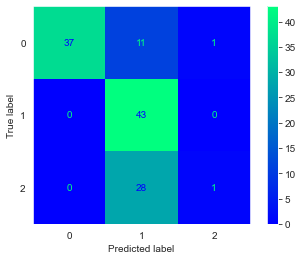

Confusion Matrix for Default MLPC
[[37 11  1]
 [ 0 43  0]
 [ 0 28  1]]
              precision    recall  f1-score   support

    COVID-19       1.00      0.76      0.86        49
      Normal       0.52      1.00      0.69        43
   Pneumonia       0.50      0.03      0.06        29

    accuracy                           0.67       121
   macro avg       0.67      0.60      0.54       121
weighted avg       0.71      0.67      0.61       121

Balanced accuracy score:
0.5965282664790054


In [36]:
# Default MLPClassifier with two changes: max_iter changed from 200 to 500 and hidden layer sizes changed from (100) to (50, 50)
# Random state set for repeatable results
def_mlp_clf = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(50, 50)).fit(list(x_train), y_train)
y_pred_def_mlp = def_mlp_clf.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_def_mlp)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_def_mlp, cmap = 'winter')
plt.grid(False)
plt.show()
print('Confusion Matrix for Default MLPC')
print(cm)
print((metrics.classification_report(y_test, y_pred_def_mlp, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print('Balanced accuracy score:')
print(metrics.balanced_accuracy_score(y_test, y_pred_def_mlp))

# Hyperparameter grid searches and best models' results
Scoring is balanced accuracy.  Best model parameters are at the end

In [42]:
# Linear SVC Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn import svm, metrics
parameters = {'loss':['hinge', 'squared_hinge'], 'C':[1, 10, 100], 'dual': [True, False], 'class_weight': [None, 'Balanced']}
svm_clf = svm.LinearSVC(random_state=42, tol=1e-2, max_iter = 2000)
svcGrid = GridSearchCV(svm_clf, parameters, scoring='balanced_accuracy', n_jobs=-1, refit=True, pre_dispatch='2*n_jobs')
svcGrid.fit(list(x_train), y_train)
print(svcGrid.best_estimator_)
print(svcGrid.best_params_)

C:\Users\imcpa\OneDrive\Documents\Data Science at DU\FinalQuarter\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imcpa\OneDrive\Documents\Data Science at DU\FinalQuarter\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imcpa\OneDrive\Documents\Data Science at DU\FinalQuarter\venv\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\i

LinearSVC(C=100, dual=False, max_iter=2000, random_state=42, tol=0.01)
{'C': 100, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge'}


In [50]:
print(svcGrid.best_estimator_)
print(svcGrid.best_params_)

LinearSVC(C=100, dual=False, max_iter=2000, random_state=42, tol=0.01)
{'C': 100, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge'}


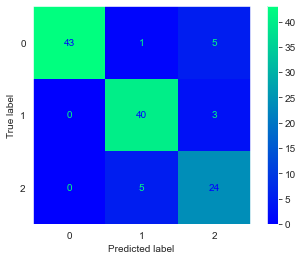

[[43  1  5]
 [ 0 40  3]
 [ 0  5 24]]
              precision    recall  f1-score   support

    COVID-19       1.00      0.88      0.93        49
      Normal       0.87      0.93      0.90        43
   Pneumonia       0.75      0.83      0.79        29

    accuracy                           0.88       121
   macro avg       0.87      0.88      0.87       121
weighted avg       0.89      0.88      0.89       121

0.8784565951480833


In [45]:
# print(svcGrid.best_score_) This line scores training data not test data
svc_estimator = svcGrid.best_estimator_
y_pred_svm = svc_estimator.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_svm)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap = 'winter')
plt.grid(False)
plt.show()
print(cm)
print((metrics.classification_report(y_test, y_pred_svm, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print(metrics.balanced_accuracy_score(y_test, y_pred_svm))

In [21]:
from sklearn.linear_model import SGDClassifier
parameters_SGD = {'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'alpha': [0.0001, 0.1, 1, 10], 'learning_rate': ['constant', 'optimal', 'invscaling'], 'class_weight': [None, 'balanced']}
sgd_clf = SGDClassifier(n_jobs = 3, early_stopping = True, random_state = 42)
sgdGrid = GridSearchCV(sgd_clf, parameters_SGD, scoring='balanced_accuracy', n_jobs=3, refit=True, pre_dispatch='2*n_jobs')
sgdGrid.fit(list(x_train), y_train)

C:\Users\imcpa\OneDrive\Documents\Data Science at DU\FinalQuarter\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imcpa\OneDrive\Documents\Data Science at DU\FinalQuarter\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imcpa\OneDrive\Documents\Data Science at DU\FinalQuarter\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 890, in fit
    return self._fit(
  File "C:\Users\imcpa\OneDrive\

GridSearchCV(estimator=SGDClassifier(early_stopping=True, n_jobs=3,
                                     random_state=42),
             n_jobs=3,
             param_grid={'alpha': [0.0001, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['hinge', 'log_loss', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron']},
             scoring='balanced_accuracy')

SGDClassifier(alpha=10, class_weight='balanced', early_stopping=True,
              loss='squared_hinge', n_jobs=3, random_state=42)
{'alpha': 10, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'squared_hinge'}


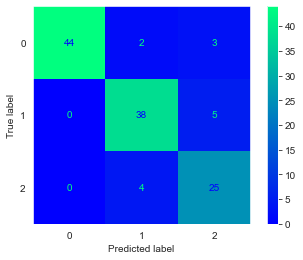

[[44  2  3]
 [ 0 38  5]
 [ 0  4 25]]
              precision    recall  f1-score   support

    COVID-19       1.00      0.90      0.95        49
      Normal       0.86      0.88      0.87        43
   Pneumonia       0.76      0.86      0.81        29

    accuracy                           0.88       121
   macro avg       0.87      0.88      0.88       121
weighted avg       0.89      0.88      0.89       121

0.8812496931410895


In [46]:
sgd_estimator = sgdGrid.best_estimator_
print(sgdGrid.best_estimator_)
print(sgdGrid.best_params_)
# print(sgdGrid.best_score_) This line gives the training score
y_pred_sgd = sgd_estimator.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_sgd)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sgd, cmap = 'winter')
plt.grid(False)
plt.show()
print(cm)
print((metrics.classification_report(y_test, y_pred_sgd, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print(metrics.balanced_accuracy_score(y_test, y_pred_sgd))

In [27]:
from sklearn.neighbors import KNeighborsClassifier
parameters_KNN = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'algorithm': ['brute','ball_tree', 'kd_tree'], 'leaf_size': [15, 30, 45]}
neigh = KNeighborsClassifier()
knnGrid = GridSearchCV(neigh, parameters_KNN, scoring='balanced_accuracy', n_jobs=3, refit=True, pre_dispatch='2*n_jobs')
knnGrid.fit(list(x_train), y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'algorithm': ['brute', 'ball_tree', 'kd_tree'],
                         'leaf_size': [15, 30, 45], 'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

KNeighborsClassifier(algorithm='brute', leaf_size=15, n_neighbors=3,
                     weights='distance')
{'algorithm': 'brute', 'leaf_size': 15, 'n_neighbors': 3, 'weights': 'distance'}


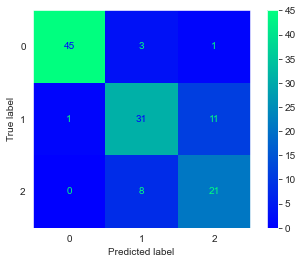

[[45  3  1]
 [ 1 31 11]
 [ 0  8 21]]
              precision    recall  f1-score   support

    COVID-19       0.98      0.92      0.95        49
      Normal       0.74      0.72      0.73        43
   Pneumonia       0.64      0.72      0.68        29

    accuracy                           0.80       121
   macro avg       0.78      0.79      0.78       121
weighted avg       0.81      0.80      0.81       121

0.7878118368437992


In [48]:
knn_estimator = knnGrid.best_estimator_
print(knnGrid.best_estimator_)
print(knnGrid.best_params_)
# print(knnGrid.best_score_) This score is based on training data not test data
y_pred_knn = knn_estimator.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_knn)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap = 'winter')
plt.grid(False)
plt.show()
print(cm)
print((metrics.classification_report(y_test, y_pred_knn, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print(metrics.balanced_accuracy_score(y_test, y_pred_knn))

Below is the MLP Classifier Grid Search.  Do not run this, it took over 24 hours to complete on my system.  I have added code to output the best model and stats after the MLPClassifier grid search

In [29]:
from sklearn.neural_network import MLPClassifier
parameters_MLP = {'max_iter': [200, 300, 400], 'hidden_layer_sizes': [(50,50), (50, 50, 50), (50), (100, 50), (50, 25), (100, 50, 25)], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}
mlp_clf = MLPClassifier(random_state=42, early_stopping = True)
mlpGrid = GridSearchCV(mlp_clf, parameters_MLP, scoring='balanced_accuracy', n_jobs=3, refit=True, pre_dispatch='2*n_jobs')
mlpGrid.fit(list(x_train), y_train)

GridSearchCV(estimator=MLPClassifier(early_stopping=True, random_state=42),
             n_jobs=3,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50), (50, 50, 50), 50,
                                                (100, 50), (50, 25),
                                                (100, 50, 25)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [200, 300, 400],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='balanced_accuracy')

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50, 50),
              max_iter=400, random_state=42, solver='lbfgs')
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'lbfgs'}


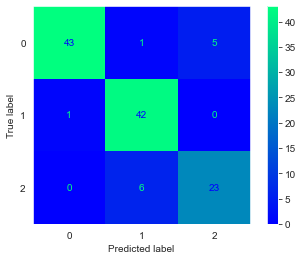

[[43  1  5]
 [ 1 42  0]
 [ 0  6 23]]
              precision    recall  f1-score   support

    COVID-19       0.98      0.88      0.92        49
      Normal       0.86      0.98      0.91        43
   Pneumonia       0.82      0.79      0.81        29

    accuracy                           0.89       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.90      0.89      0.89       121

0.8824662182435122


In [49]:
mlp_estimator = mlpGrid.best_estimator_
print(mlpGrid.best_estimator_)
print(mlpGrid.best_params_)
# print(mlpGrid.best_score_) this line shows the best training score not test score
y_pred_mlp = mlp_estimator.predict(list(x_test))
mlp_estimator.score(list(x_test), y_test)
cm = metrics.confusion_matrix(y_test, y_pred_mlp)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, cmap = 'winter')
plt.grid(False)
plt.show()
print(cm)
print((metrics.classification_report(y_test, y_pred_mlp, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print(metrics.balanced_accuracy_score(y_test, y_pred_mlp))

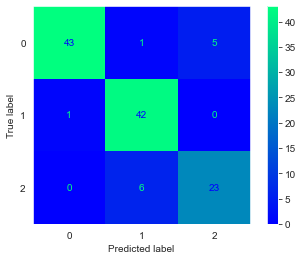

Confusion Matrix for Best MLPC
[[43  1  5]
 [ 1 42  0]
 [ 0  6 23]]
              precision    recall  f1-score   support

    COVID-19       0.98      0.88      0.92        49
      Normal       0.86      0.98      0.91        43
   Pneumonia       0.82      0.79      0.81        29

    accuracy                           0.89       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.90      0.89      0.89       121

Balanced accuracy score:
0.8824662182435122


In [38]:
best_mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50, 50), max_iter=400, random_state=42, solver='lbfgs', activation = 'relu', learning_rate = 'constant').fit(list(x_train), y_train)
y_pred_best_mlp = best_mlp_clf.predict(list(x_test))
cm = metrics.confusion_matrix(y_test, y_pred_best_mlp)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_mlp, cmap = 'winter')
plt.grid(False)
plt.show()
print('Confusion Matrix for Best MLPC')
print(cm)
print((metrics.classification_report(y_test, y_pred_best_mlp, target_names = ['COVID-19', 'Normal', 'Pneumonia'])))
print('Balanced accuracy score:')
print(metrics.balanced_accuracy_score(y_test, y_pred_best_mlp))

# Best model parameters
LinearSVC(C=100, dual=False, max_iter=2000, random_state=42, tol=0.01)
{'C': 100, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge'}

SGDClassifier(alpha=10, class_weight='balanced', early_stopping=True,
              loss='squared_hinge', n_jobs=3, random_state=42)
{'alpha': 10, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'squared_hinge'}

KNeighborsClassifier(algorithm='brute', leaf_size=15, n_neighbors=3,
                     weights='distance')
{'algorithm': 'brute', 'leaf_size': 15, 'n_neighbors': 3, 'weights': 'distance'}

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50, 50),
              max_iter=400, random_state=42, solver='lbfgs')
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'lbfgs'}